# Credit Risk Assessment Reports Powered by Gen AI

Objective -
To create an agent that can provide end-users with a concise report about the rationale behind why a certain user has their loan_status as 0 (not likely to default) or 1 (likely to default).

Steps -
1. We create a logistic regression model trained on our labelled data to understand the coefficients for each of the variables
2. The coefficients are provided to the LLM as a prompt along with instructions on how we would want the agent to provide reports for each of the users
3. The fine-tuned model is generated based on training data. We have used 10 samples to train the LLM
4. An output in the form of a crisp 100-word paragraph is generated for end-users

Data source - https://assets.datacamp.com/production/repositories/4876/datasets/2f6c17f10d5156a29670d1926fdf7125c002e038/cr_loan_w2.csv

As per our understanding, the model accounts for the 5Cs of credit risk (character, capacity, capital, collateral and conditions) while providing us with a report.

Notes - While the term of the loan, amount of monthly installments along with a hundreds of other factors usually go into these models, they are not present in the readily available dataset. We have not acccounted for the real-world complexity of these models in our demo, but the solution we have created can certainly scale to consider these as well.


In [ ]:
#import required libraries
import sklearn
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("loan_clean_data.csv")

df.head()

,user_id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,1,21,9600,5,1000,11.14,0,0.10,2,0,...,0,0,1,0,0,0,0,0,1,0
1,2,25,9600,1,5500,12.87,1,0.57,3,1,...,0,0,0,1,0,0,0,0,1,0
2,3,23,65500,4,35000,15.23,1,0.53,2,0,...,0,0,0,1,0,0,0,0,1,0
3,4,24,54400,8,35000,14.27,1,0.55,4,0,...,0,0,0,1,0,0,0,0,0,1
4,5,21,9900,2,2500,7.14,1,0.25,2,0,...,1,1,0,0,0,0,0,0,1,0


In [ ]:
#drop dependent variable, unique user identifier & map dependent labeled data
X = df.drop(['loan_status','user_id'], axis=1)
y = df['loan_status']

In [ ]:
#split into train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
#create and fit a logistic regression model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#predict based on trained model
pred_model = model.predict(X_test)

In [ ]:
#display coefficients for indepdent variables
coef = model.coef_
coef

array([[-7.84946293e-08, -4.01224215e-05, -3.15440303e-08,
         1.06267684e-04,  9.56629261e-08,  2.52197035e-09,
        -1.55965867e-08, -7.23156777e-09,  5.17987273e-11,
        -4.40885521e-09,  8.66343105e-09,  3.06908047e-09,
        -3.48461434e-09,  1.75385270e-09,  1.31455501e-09,
        -1.32176296e-09, -4.25630409e-09, -1.18659499e-08,
        -6.33796783e-09, -1.67987803e-09,  1.14488214e-08,
         3.98188307e-09,  1.09762203e-09,  4.30275968e-10,
        -1.05194256e-08,  7.59423240e-09]])

In [ ]:
#compute accuracy and generated classification report
from sklearn.metrics import accuracy_score, classification_report
print("The accuracy of logit model is:", accuracy_score(y_test, pred_model))
print(classification_report(y_test, pred_model))

The accuracy of logit model is: 0.8090065625707173
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6930
           1       0.73      0.18      0.29      1908

    accuracy                           0.81      8838
   macro avg       0.77      0.58      0.59      8838
weighted avg       0.80      0.81      0.76      8838



In [ ]:
#identify independent variables
temp_df = df.columns.drop(['user_id','loan_status'])
np_df = temp_df.to_numpy()
np_df

array(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL',
       'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y'], dtype=object)

In [ ]:
#map indepedent variables to coefficients
dict = {}

for i in range(len(np_df)):
    dict[np_df[i]] = coef[0][i]

A dictionary is created mapping the indepedent variables to their respective coefficients for the "system_message" prompt of our LLM

In [ ]:
dict

{'person_age': -7.849462925004466e-08,
 'person_income': -4.012242152273084e-05,
 'person_emp_length': -3.1544030326822723e-08,
 'loan_amnt': 0.00010626768411742603,
 'loan_int_rate': 9.566292610149531e-08,
 'loan_percent_income': 2.5219703457971187e-09,
 'cb_person_cred_hist_length': -1.559658670015244e-08,
 'person_home_ownership_MORTGAGE': -7.2315677715852386e-09,
 'person_home_ownership_OTHER': 5.179872731926357e-11,
 'person_home_ownership_OWN': -4.408855212196025e-09,
 'person_home_ownership_RENT': 8.663431050209117e-09,
 'loan_intent_DEBTCONSOLIDATION': 3.069080467794911e-09,
 'loan_intent_EDUCATION': -3.4846143393036416e-09,
 'loan_intent_HOMEIMPROVEMENT': 1.7538527003755668e-09,
 'loan_intent_MEDICAL': 1.314555012259882e-09,
 'loan_intent_PERSONAL': -1.3217629594360011e-09,
 'loan_intent_VENTURE': -4.256304087943603e-09,
 'loan_grade_A': -1.1865949860858496e-08,
 'loan_grade_B': -6.337967832177201e-09,
 'loan_grade_C': -1.6798780286661284e-09,
 'loan_grade_D': 1.14488214497615

## Initializing libraries and data for fine-tuning

Fine-tuning ChatGPT involves adjusting the pre-trained model using additional data specific to a particular task or domain. This process helps improve the model's performance on tasks beyond its original training data.

Our objective was to fine-tune the LLM based on our logistic regression model's coefficients & some sample outputs to enable it to effectively understand why our model arrived at a certain credit assessment outcome for a particular applicant.

Steps to employed to create a fine-tuned model:

1. Select a Pre-trained Model: Choose a suitable ChatGPT model.
2. Collect Data: Gather relevant dataset.
3. Fine-tuning Steps: Model initialization, fine-tuning, and validation.
4. Evaluation: Assess the model's performance.
5. Deployment: Deploy the fine-tuned model.

In [ ]:
#install latest version of the openai python package
!pip install --upgrade openai

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#install necessary libraries & packages
import json
import openai
import os
import pandas as pd
from pprint import pprint

#provide the Open AI API secret key
client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "ENTER_YOUR_KEY_HERE"))

The data for all attributes is converted into an object for ingestion into the LLM.

In [ ]:
df = pd.read_csv("use_loan_data.csv")

df.head()

,user_id,attributes,output
0,1,"['user_id 1','person_age 21','person_income 96...","For user_id = 1, the loan_status is 0, indicat..."
1,2,"['user_id 2','person_age 25','person_income 96...","For user_id = 2, the loan_status is 1, indicat..."
2,3,"['user_id 3','person_age 23','person_income 65...","For user_id = 3, the loan_status is 1, indicat..."
3,4,"['user_id 4','person_age 24','person_income 54...","For user_id = 4, the loan_status is 1, indicat..."
4,5,"['user_id 5','person_age 21','person_income 99...","For user_id = 5, the loan_status is 1, indicat..."


## Data preparation



In [ ]:
#create training data with content for system, user and assistant roles
training_data = []

system_message = "You are an assistant to a credit analyst responsible to provide a concise summary of no more than 100 words on why a certain user id has their loan outcome as 1 meaning default or 0 meaning will not default on the loan. Refer to this data for understanding what are the key factors that contributed towards the loan_status person_age -7.849462925004466e-08 person_income -4.012242152273084e-05 person_emp_length -3.1544030326822723e-08 loan_amnt 0.00010626768411742603 loan_int_rate 9.566292610149531e-08 loan_percent_income 2.5219703457971187e-09 cb_person_cred_hist_length -1.559658670015244e-08 person_home_ownership_MORTGAGE -7.2315677715852386e-09 person_home_ownership_OTHER 5.179872731926357e-11 person_home_ownership_OWN -4.408855212196025e-09 person_home_ownership_RENT 8.663431050209117e-09 loan_intent_DEBTCONSOLIDATION 3.069080467794911e-09 loan_intent_EDUCATION -3.4846143393036416e-09 loan_intent_HOMEIMPROVEMENT 1.7538527003755668e-09 loan_intent_MEDICAL 1.314555012259882e-09 loan_intent_PERSONAL -1.3217629594360011e-09 loan_intent_VENTURE -4.256304087943603e-09 loan_grade_A -1.1865949860858496e-08 loan_grade_B -6.337967832177201e-09 loan_grade_C -1.6798780286661284e-09 loan_grade_D 1.1448821449761577e-08 loan_grade_E 3.981883066102988e-09 loan_grade_F 1.0976220320634127e-09 loan_grade_G 4.3027596752097147e-10 cb_person_default_on_file_N -1.0519425603659041e-08 cb_person_default_on_file_Y 7.59423239740616e-09"
def create_user_message(row):
    return f"""{row['attributes']}"""

def prepare_example_conversation(row):
    messages = []
    messages.append({"role": "system", "content": system_message})

    user_message = create_user_message(row)
    messages.append({"role": "user", "content": user_message})

    messages.append({"role": "assistant", "content": row["output"]})

    return {"messages": messages}

pprint(prepare_example_conversation(df.iloc[0]))

{'messages': [{'content': 'You are an assistant to a credit analyst '
                          'responsible to provide a concise summary of no more '
                          'than 100 words on why a certain user id has their '
                          'loan outcome as 1 meaning default or 0 meaning will '
                          'not default on the loan. Refer to this data for '
                          'understanding what are the key factors that '
                          'contributed towards the loan_status person_age '
                          '-7.849462925004466e-08 person_income '
                          '-4.012242152273084e-05 person_emp_length '
                          '-3.1544030326822723e-08 loan_amnt '
                          '0.00010626768411742603 loan_int_rate '
                          '9.566292610149531e-08 loan_percent_income '
                          '2.5219703457971187e-09 cb_person_cred_hist_length '
                          '-1.559658670015244e-0

In [ ]:
#use the first 10 rows of the dataset for training
training_df = df.loc[0:9]

#apply the prepare_example_conversation function to each row of the training_df
training_data = training_df.apply(prepare_example_conversation, axis=1).tolist()

for example in training_data[:5]:
    print(example)

{'messages': [{'role': 'system', 'content': 'You are an assistant to a credit analyst responsible to provide a concise summary of no more than 100 words on why a certain user id has their loan outcome as 1 meaning default or 0 meaning will not default on the loan. Refer to this data for understanding what are the key factors that contributed towards the loan_status person_age -7.849462925004466e-08 person_income -4.012242152273084e-05 person_emp_length -3.1544030326822723e-08 loan_amnt 0.00010626768411742603 loan_int_rate 9.566292610149531e-08 loan_percent_income 2.5219703457971187e-09 cb_person_cred_hist_length -1.559658670015244e-08 person_home_ownership_MORTGAGE -7.2315677715852386e-09 person_home_ownership_OTHER 5.179872731926357e-11 person_home_ownership_OWN -4.408855212196025e-09 person_home_ownership_RENT 8.663431050209117e-09 loan_intent_DEBTCONSOLIDATION 3.069080467794911e-09 loan_intent_EDUCATION -3.4846143393036416e-09 loan_intent_HOMEIMPROVEMENT 1.7538527003755668e-09 loan_

We save our data as `.jsonl` files, with each line being one training example conversation.

In [ ]:
#save data as .jsonl files
def write_jsonl(data_list: list, filename: str) -> None:
    with open(filename, "w") as out:
        for ddict in data_list:
            jout = json.dumps(ddict) + "\n"
            out.write(jout)

As mentioned in the Open AI documentation, we need a minimum of 10 examples for fine-tuning models. Since validation data is **optional**, we have not utilized it.

In [ ]:
#create training file
training_file_name = "tmp_cr_finetune_training.jsonl"
write_jsonl(training_data, training_file_name)

This is what the first 5 lines of our training `.jsonl` file look like:

In [ ]:
#print the first 5 lines of the training file
!head -n 5 tmp_cr_finetune_training.jsonl

{"messages": [{"role": "system", "content": "You are an assistant to a credit analyst responsible to provide a concise summary of no more than 100 words on why a certain user id has their loan outcome as 1 meaning default or 0 meaning will not default on the loan. Refer to this data for understanding what are the key factors that contributed towards the loan_status person_age -7.849462925004466e-08 person_income -4.012242152273084e-05 person_emp_length -3.1544030326822723e-08 loan_amnt 0.00010626768411742603 loan_int_rate 9.566292610149531e-08 loan_percent_income 2.5219703457971187e-09 cb_person_cred_hist_length -1.559658670015244e-08 person_home_ownership_MORTGAGE -7.2315677715852386e-09 person_home_ownership_OTHER 5.179872731926357e-11 person_home_ownership_OWN -4.408855212196025e-09 person_home_ownership_RENT 8.663431050209117e-09 loan_intent_DEBTCONSOLIDATION 3.069080467794911e-09 loan_intent_EDUCATION -3.4846143393036416e-09 loan_intent_HOMEIMPROVEMENT 1.7538527003755668e-09 loan_

### Upload files

We now upload the files to our `Files` endpoint to be used by the fine-tuned model.

In [ ]:
with open(training_file_name, "rb") as training_fd:
    training_response = client.files.create(
        file=training_fd, purpose="fine-tune"
    )

training_file_id = training_response.id

print("Training file ID:", training_file_id)

Training file ID: file-5XdcD73L31a1xcUYaYsHlzQX


## Fine-tuning

Next, we create our fine-tuning job with the generated files and an optional suffix to identify the model. The response will contain an `id` which you can use to retrieve updates on the job.

In [ ]:
response = client.fine_tuning.jobs.create(
    training_file=training_file_id,
    model="gpt-3.5-turbo",
    suffix="recipe-ner",
)

job_id = response.id

print("Job ID:", response.id)
print("Status:", response.status)

Job ID: ftjob-NXPGhB0BvZY6Edhv7Vs6oXwP
Status: validating_files


In [ ]:
#check status of the job ID
response = client.fine_tuning.jobs.retrieve(job_id)

print("Job ID:", response.id)
print("Status:", response.status)
print("Trained Tokens:", response.trained_tokens)

Job ID: ftjob-NXPGhB0BvZY6Edhv7Vs6oXwP
Status: validating_files
Trained Tokens: None


We can track the progress of the fine-tune with the events endpoint. You can rerun the cell below a few times until the fine-tune is ready.


In [ ]:
#check if fine-tuned model is ready
response = client.fine_tuning.jobs.list_events(job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)

Created fine-tuning job: ftjob-NXPGhB0BvZY6Edhv7Vs6oXwP
Validating training file: file-MLJx91KbaTiGY1PopJf6jDvY and validation file: file-BTt5J91tTVUxEZcawgvZXEi2


**Screenshot of success message for fine-tuning job:**

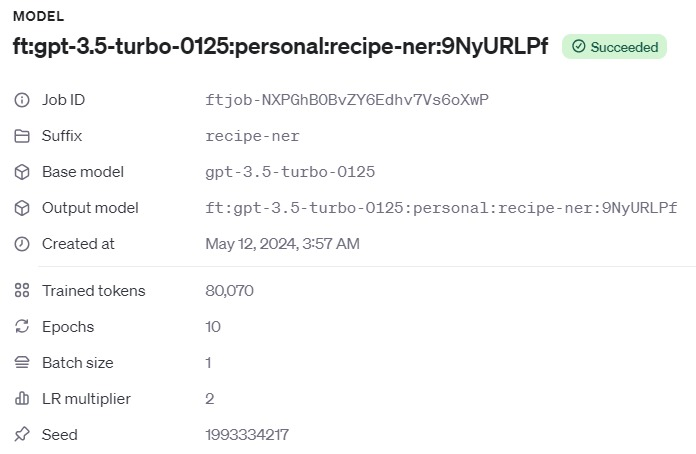

In [ ]:
#obtain model ID
response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError("Fine-tuned model ID not found. Your job has likely not been completed yet.")

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-3.5-turbo-0125:personal:recipe-ner:9NyURLPf


## Inference

In [ ]:
#Test-case 1
test_df = df.loc[101:110]
test_row = test_df.iloc[3]
test_messages = []
test_messages.append({"role": "system", "content": system_message})
user_message = create_user_message(test_row)
test_messages.append({"role": "user", "content": user_message})

In [ ]:
#Response 1
response = client.chat.completions.create(
    model=fine_tuned_model_id, messages=test_messages, temperature=0, max_tokens=500
)

pprint(response.choices[0].message.content)

('For user_id = 105, the loan_status is 1, indicating a predicted default on '
 'the loan. Despite a decent income, the loan amount is significant compared '
 'to their income, with a loan_percent_income ratio of 59%, suggesting '
 'potential financial strain. Additionally, the person is relatively young, '
 'has a short employment length of 1 year, and does not own their home, which '
 'may indicate a less stable financial situation. These factors, along with a '
 'moderate credit history, contribute to the model predicting a higher risk of '
 'default for this user.')


In [ ]:
#Test-case 2
test_df_2 = df.loc[200:300]
test_row_2 = test_df_2.iloc[77]
test_messages_2 = []
test_messages_2.append({"role": "system", "content": system_message})
user_message_2 = create_user_message(test_row_2)
test_messages_2.append({"role": "user", "content": user_message_2})

In [ ]:
#Response 2
response_2 = client.chat.completions.create(
    model=fine_tuned_model_id, messages=test_messages_2, temperature=0, max_tokens=500
)

pprint(response_2.choices[0].message.content)

('For user_id = 278, the loan_status is 0, indicating they are not predicted '
 'to default on the loan. Despite being relatively young (24 years old), the '
 'user has a high income of $110,000 and a stable employment length of 7 '
 'years. The loan amount is substantial, but the loan_percent_income ratio is '
 '23%, suggesting they have a strong financial position to handle the debt. '
 'Additionally, they do not have any other major financial obligations, such '
 'as a mortgage. These factors collectively contribute to the model predicting '
 'a lower risk of default for this user.')


## Questions

Our model has been fine-tuned based on a detailed system_message prompt mentioned above. The objective was to make it capable of providing crisp reports that answer the following questions that come up during traditional internal enquiries before offering a loan to an applicant:

1. Why is a particular applicant predicted to default or not default on their loan based on their existing data?
2. Which obvious and non-obvious factors are contributing to the prediction?
3. What is the weightage of these factors in determining the outcome?
4. The applicant has a relatively short credit history, what are some other metrics that can offer us the confidence that this loan applicant can successfully pay off their loan?
5. Despite a higher income, why is a certain applicant still predicted to default on a loan? (Example in Response 3)
6. How does the model justify a moderately-high loan-to-income ratio?
7. For certain edge cases, our solution can also answers questions pertaining to understanding justifications behind decisions that may seem incorrect when evaluated by experts manually. This is where our model fails currently but understanding the logic & its flaws can help train the model to improve upon it. (Example in Response 4. The loan currently amounts to 83% of a person's income which is concerning and might not have been approved in an ideal traditional scenario.)
8. Do we have subtantial justification to support approvals for applicants that have previously defaulted on their loans?
9. When compared to other factors, does age outweight the importance of other factors? (Example in Response 5)   
10. How does the a certain person's ownership of property correlate with their financial capacity and potential to pay back on loan while incorporating other available financial metrics?

In [ ]:
#Test-case 3
test_df_3 = df.loc[1:20]
test_row_3 = test_df_3.iloc[10]
test_messages_3 = []
test_messages_3.append({"role": "system", "content": system_message})
user_message_3 = create_user_message(test_row_3)
test_messages_3.append({"role": "user", "content": user_message_3})

In [ ]:
#Response 3
response_3 = client.chat.completions.create(
    model=fine_tuned_model_id, messages=test_messages_3, temperature=0, max_tokens=500
)

pprint(response_3.choices[0].message.content)

('For user_id = 12, the loan_status is 1, indicating a predicted default on '
 'the loan. Despite a relatively high income, the loan amount is substantial '
 'compared to their income, with a loan_percent_income ratio of 37%, '
 'suggesting potential financial strain. Additionally, the person has a short '
 'employment length of 2 years and does not own their home, which may indicate '
 'a less stable financial situation. With a short credit history and several '
 'factors pointing towards higher financial risk, the model predicts a higher '
 'likelihood of default for this user.')


In [ ]:
#Test-case 4
test_df_4 = df.loc[500:600]
test_row_4 = test_df_4.iloc[71]
test_messages_4 = []
test_messages_4.append({"role": "system", "content": system_message})
user_message_4 = create_user_message(test_row_4)
test_messages_4.append({"role": "user", "content": user_message_4})

In [ ]:
#Response 4
response_4 = client.chat.completions.create(
    model=fine_tuned_model_id, messages=test_messages_4, temperature=0, max_tokens=500
)

pprint(response_4.choices[0].message.content)

('For user_id = 572, the loan_status is 0, indicating they are not predicted '
 'to default on the loan. Despite being relatively young (22 years old) and '
 'having a low income, the loan amount is substantial compared to their '
 'income, with a loan_percent_income ratio of 83%, which could be concerning. '
 'However, the person owns a mortgage, which may indicate a more stable '
 'financial situation. Additionally, although the person has a short '
 'employment length of 0 years, other factors such as a decent credit history '
 'and certain ownership status may have contributed to the model predicting a '
 'lower risk of default for this user.')


In [ ]:
#Test-case 5
test_df_5 = df.loc[20000:30000]
test_row_5 = test_df_5.iloc[9408]
test_messages_5 = []
test_messages_5.append({"role": "system", "content": system_message})
user_message_5 = create_user_message(test_row_5)
test_messages_5.append({"role": "user", "content": user_message_5})

In [ ]:
#Response 5
response_5 = client.chat.completions.create(
    model=fine_tuned_model_id, messages=test_messages_5, temperature=0, max_tokens=500
)

pprint(response_5.choices[0].message.content)

('For user_id = 29409, the loan_status is 1, indicating a predicted default on '
 'the loan. Despite a relatively high income, the person has a short '
 'employment length of 0 years and is 70 years old, which may indicate a less '
 'stable financial situation. Additionally, the loan amount is significant '
 'compared to their income, with a loan_percent_income ratio of 31%, '
 'suggesting potential financial strain. The person does not own their home '
 'and has a long credit history, but these factors may not be sufficient to '
 'offset the higher risk associated with the combination of age, low '
 'employment length, and high loan amount.')
